In [81]:
from sympy import init_session
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.integrate as it
from scipy.signal import savgol_filter

init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [82]:
# Size
a = 1.78 * 0.0254 #m R2
b = 12.1 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1



In [83]:
m = 3.48 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/3 * m * l**2 + m * (l/2 * sqrt(3))**2 + 1/3 * m * (l/2)**2 #moment of inertia about com kgm^2 
mu_k = 0.3  # coefficien()t of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 25 #degs
n = 3 # order of polynomial filtering 
b = 53 # window size for filter need to be odd number


In [84]:
#Parameters
motor_torque = 30 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["time [s]", "theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_3 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])


In [85]:
#Torque Calculations

tau_out = []

err = 15 # to eliminate spikes and use small angle approximation

for i in range(df.shape[0]):
    theta_a = 180.0 - df["theta_2 [°]"][i] + df["theta_3 [°]"][i] # inner angle between link a and b
    theta_b = df["theta_4 [°]"][i]- df["theta_3 [°]"][i] # inner angle between link b and c
    if abs(theta_a) > err and abs(theta_a) < (180-err):
        temp1 = motor_torque * ((c * np.sin(np.deg2rad(theta_b)))/ (a * np.sin(np.deg2rad(theta_a))))
        tau_out.append(temp1)
    elif abs(theta_b) < err and abs(theta_a) > (180-err):
        temp2 = motor_torque * (c * np.sin(np.deg2rad(theta_b)))/ (a * theta_a)
        tau_out.append(temp2)
    else: 
        temp3 = motor_torque * (c* np.sin(np.deg2rad(theta_b)))/ (a* theta_a)
        tau_out.append(temp3)

filter_tau_out = savgol_filter(tau_out, b, n)
tau_c = np.linspace(-motor_torque / 2,motor_torque / 2,301)
df["Input_torque [nm]"] = tau_out
#print(df["Input_torque [nm]"].to_string())

In [86]:
# Equations of Motion
acceleration_t = []
force_spring = []
alpha_w = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = (df["Input_torque [nm]"][i] / 2) * ( 1 / (I - 0.25 * m * l**2))  #alpha
    #temp7 = (df["Input_torque [nm]"][i] / I)   #alpha
    alpha_w.append(temp7)
    
    temp8 = alpha_w[i] * l / 2 #use a = r*alpha to find alpha
    acceleration_t.append(temp8)
    
    temp9 = (df["Input_torque [nm]"][i] / l) - (m * l * alpha_w[i] / 2)#friction
    F_friction.append(temp8)

    temp10 = F_friction[i] / mu_k #Normal force
    F_n.append(temp10)
    
    temp11 = F_n[i] - m * g * np.cos(np.radians(theta)) #Spring Force
    force_spring.append(temp11)
    
df["F_normal [N]"] = F_n
df["Friction [N]"] = F_friction
df["acc_tan [m/s^2]"] = acceleration_t 
df["alpha_w [rad/s^2]"] = alpha_w
df["F_spring [N]"]= force_spring
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_3 [rad/s],omega_4 [rad/s],alpha_2 [rad/s^2],alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N]
0,0.00,4.712389,0.353544,2.273354,270.000000,20.256570,130.253603,6.81,0.684998,-3.796122,0.0,-9.697918,-2.390415,-53.515733,-22.4651718054628,-6.73955154163884,-6.73955154163884,-21.6601367238915,-53.4054320855496
1,0.01,4.712389,0.353544,2.273354,270.000000,20.256570,130.253603,6.81,0.684998,-3.796122,0.0,-9.697918,-2.390415,-53.515733,-22.4651718054628,-6.73955154163884,-6.73955154163884,-21.6601367238915,-53.4054320855496
2,0.02,4.780489,0.359904,2.235282,273.901843,20.620969,128.072234,6.81,0.586502,-3.817393,0.0,-9.993734,-1.851352,-53.217541,-22.3399952037870,-6.70199856113609,-6.70199856113609,-21.5394458014980,-53.2802554838738
3,0.03,4.848589,0.365265,2.197026,277.803685,20.928131,125.880297,6.81,0.485282,-3.832882,0.0,-10.241933,-1.232148,-53.002482,-22.2497161341418,-6.67491484024255,-6.67491484024255,-21.4524018648322,-53.1899764142286
4,0.04,4.916689,0.369602,2.158647,281.705528,21.176637,123.681343,6.81,0.381841,-3.841730,0.0,-10.436766,-0.521192,-52.880413,-22.1984732009989,-6.65954196029966,-6.65954196029966,-21.4029952122759,-53.1387334810856


In [87]:
#Use trapezoidal rule to find v by integration
dt = 0.0001
v_tan = it.cumulative_trapezoid(df["acc_tan [m/s^2]"], df["time [s]"], initial = 0.0)
omega_w = it.cumulative_trapezoid(df["alpha_w [rad/s^2]"], x = df["time [s]"], dx = dt, initial = 0.0)
df["vel_tan [m/s]"] = v_tan
df["omega_w [rad/s]"] = omega_w


In [88]:
#Use trapezoidal rule to find position by integration
dt = 0.01
x_cor = []
y_cor = []
tan = it.cumulative_trapezoid(df["vel_tan [m/s]"], dx = dt, initial = 0.0)
theta_w = it.cumulative_trapezoid(df["omega_w [rad/s]"], x = df["time [s]"],dx = dt, initial = 0.0)
df["pos_tan [m]"] = tan 
df["pos_angular [rad]"] = theta_w
df["pos_angular [°]"] = (theta_w * 180 /np.pi) % 360
for i in range(df.shape[0]):
    temp20 = abs(l/2 * cos(theta_w[i])) + 0
    x_cor.append(temp20)
    temp21 = abs(l/2 * sin(theta_w[i]))+ 0
    y_cor.append(temp21)
df["position x [m]"] = x_cor
df["position y [m]"] = y_cor

#print(df["pos_angular [rad]"].to_string())



In [89]:
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_3 [rad/s],omega_4 [rad/s],...,acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N],vel_tan [m/s],omega_w [rad/s],pos_tan [m],pos_angular [rad],pos_angular [°],position x [m],position y [m]
0,0.00,4.712389,0.353544,2.273354,270.000000,20.256570,130.253603,6.81,0.684998,-3.796122,...,-6.73955154163884,-21.6601367238915,-53.4054320855496,0.0,0.0,0.0,0.0,0.0,0.311150000000000,0
1,0.01,4.712389,0.353544,2.273354,270.000000,20.256570,130.253603,6.81,0.684998,-3.796122,...,-6.73955154163884,-21.6601367238915,-53.4054320855496,-0.0673955154163884,-0.216601367238915,-0.000336977577081942,-0.00108300683619457,359.937948279102,0.311149817525508,0.000336977511208232
2,0.02,4.780489,0.359904,2.235282,273.901843,20.620969,128.072234,6.81,0.586502,-3.817393,...,-6.70199856113609,-21.5394458014980,-53.2802554838738,-0.134603265930263,-0.432599279865862,-0.00134697148381520,-0.00432901007171846,359.751965993421,0.311147084477993,0.00134696727670453
3,0.03,4.848589,0.365265,2.197026,277.803685,20.928131,125.880297,6.81,0.485282,-3.832882,...,-6.67491484024255,-21.4524018648322,-53.1899764142286,-0.201487832937156,-0.647558518197513,-0.00302742697815230,-0.00972979906203534,359.442523578235,0.311135271988105,0.00302737921113612
4,0.04,4.916689,0.369602,2.158647,281.705528,21.176637,123.681343,6.81,0.381841,-3.841730,...,-6.65954196029966,-21.4029952122759,-53.1387334810856,-0.268160116939867,-0.861835503583054,-0.00537566672753741,-0.0172767691709382,359.010114042884,0.311103564078464,0.00537539930397746


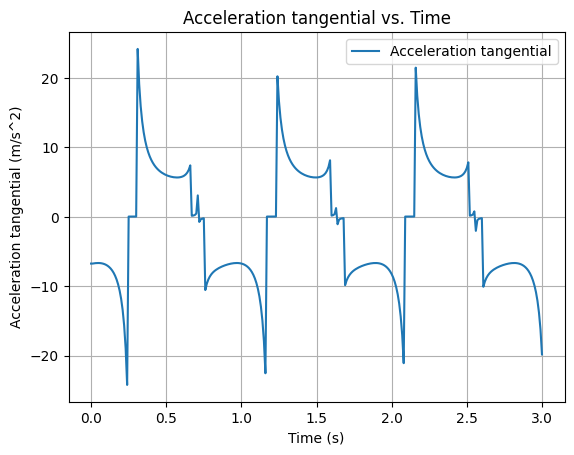

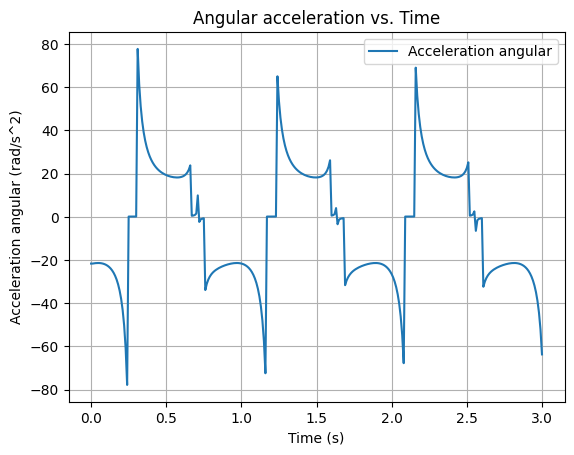

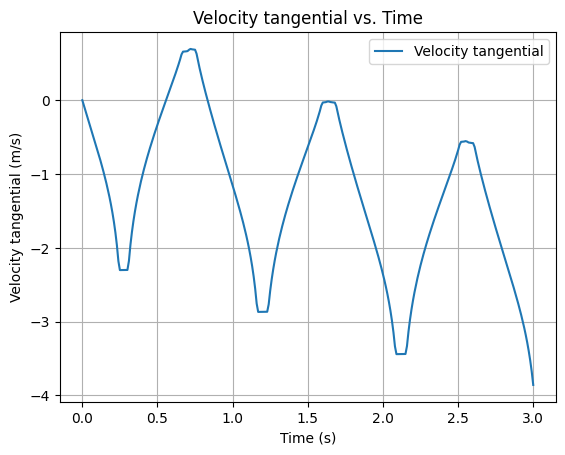

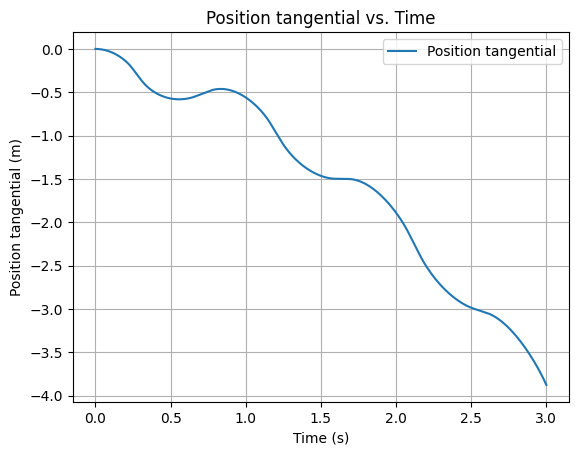

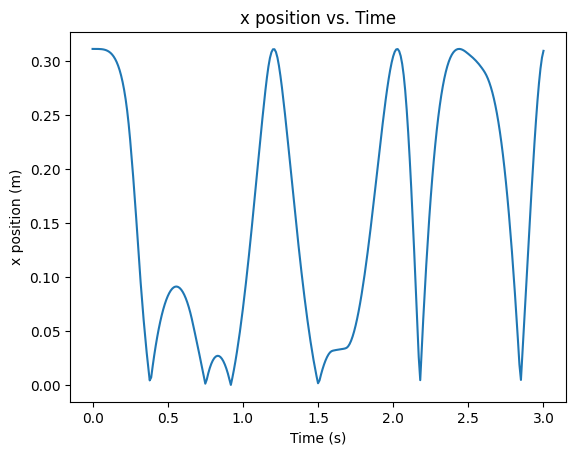

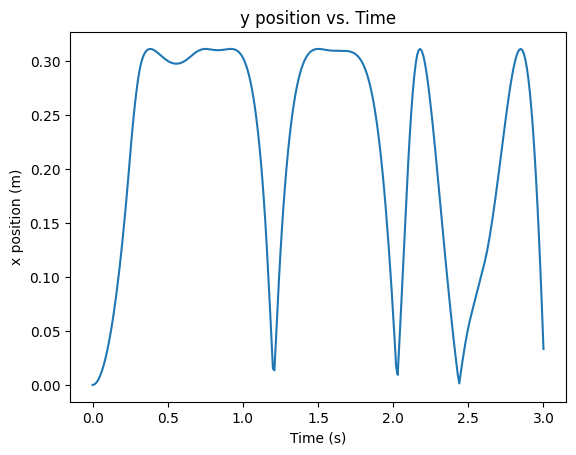

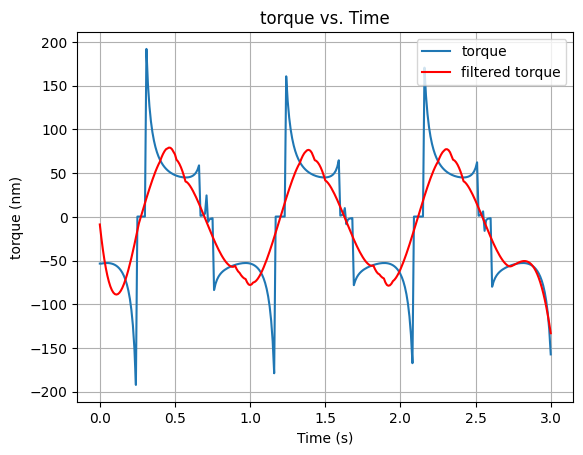

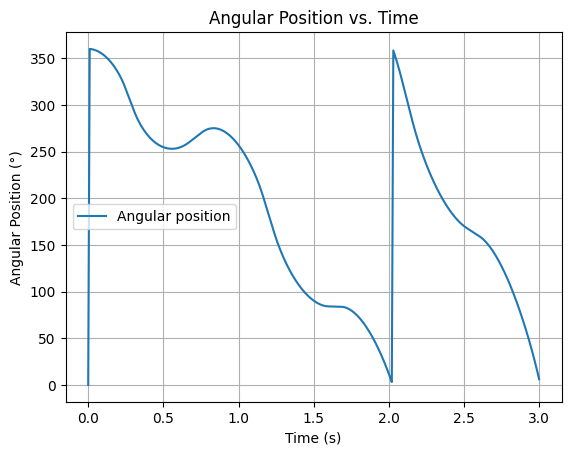

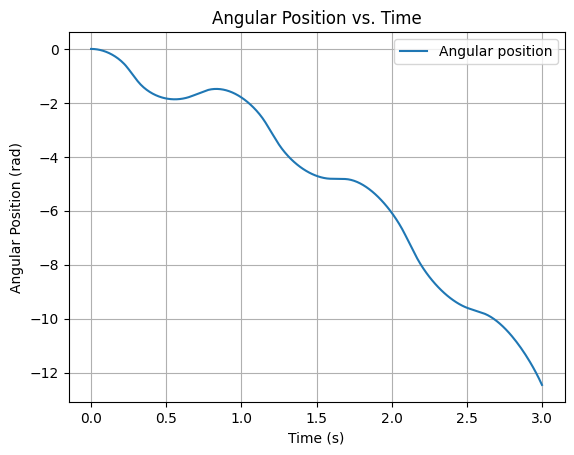

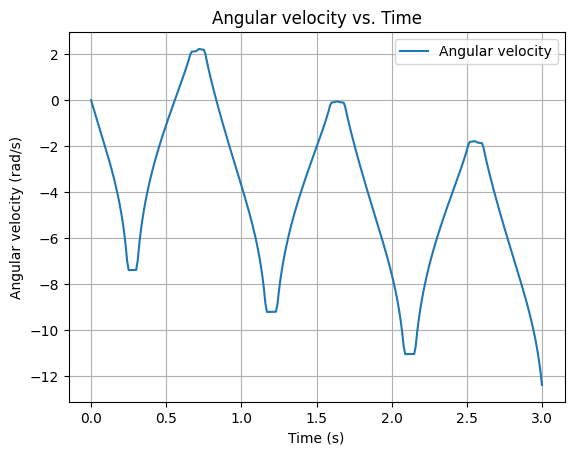

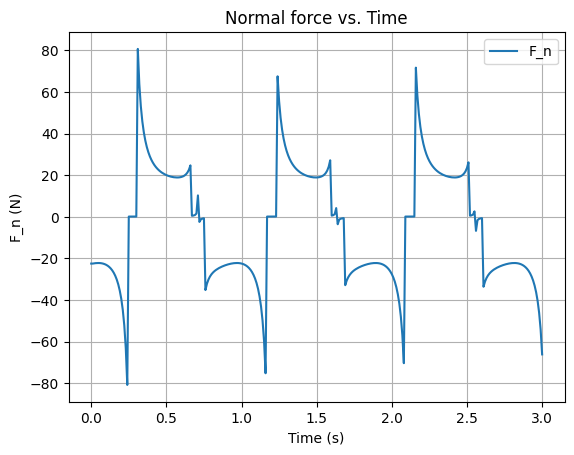

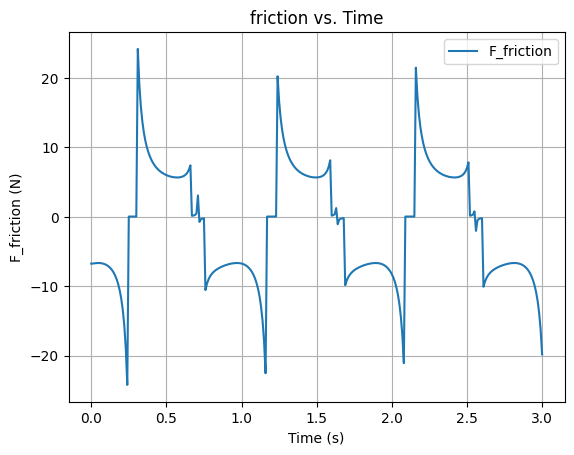

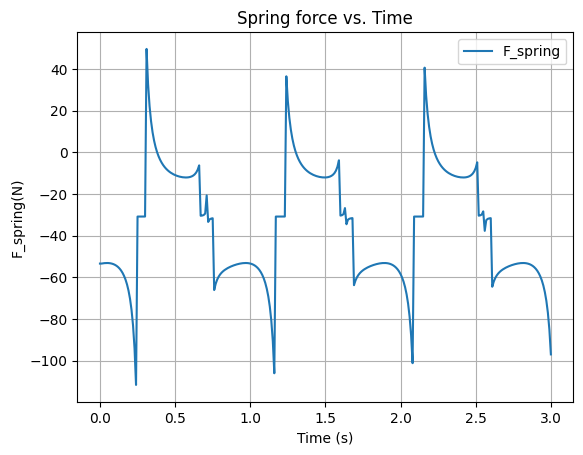

In [90]:
# Plotting the graphs

plt.plot(df["time [s]"], df["acc_tan [m/s^2]"], label='Acceleration tangential')
#plt.plot(df["time [s]"], l * df["alpha_4 [rad/s^2]"], label='FR Acceleration', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration tangential (m/s^2)')
plt.title('Acceleration tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["alpha_w [rad/s^2]"], label='Acceleration angular')
#plt.plot(df["time [s]"], df["alpha_4 [rad/s^2]"], label='ang accel fr fr ', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration angular (rad/s^2)')
plt.title('Angular acceleration vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["vel_tan [m/s]"] , label='Velocity tangential')
plt.xlabel('Time (s)')
plt.ylabel('Velocity tangential (m/s)')
plt.title('Velocity tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_tan [m]"] , label='Position tangential')
plt.xlabel('Time (s)')
plt.ylabel('Position tangential (m)')
plt.title('Position tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["position x [m]"], label='x position')
plt.xlabel('Time (s)')
plt.ylabel('x position (m)')
plt.title('x position vs. Time')
plt.show()

plt.plot(df["time [s]"], df["position y [m]"], label='x position')
plt.xlabel('Time (s)')
plt.ylabel('x position (m)')
plt.title('y position vs. Time')
plt.show()

plt.plot(df["time [s]"], tau_out, label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')

plt.grid()
yhat = savgol_filter(df["Input_torque [nm]"], b, n) # window size b, polynomial order n
plt.plot(df["time [s]"], yhat, label = 'filtered torque', color = 'red')
plt.legend()
plt.show()

plt.plot(df["time [s]"], df["pos_angular [°]"] , label='Angular position')
plt.xlabel('Time (s)')
plt.ylabel('Angular Position (°)')
plt.title('Angular Position vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_angular [rad]"] , label='Angular position')
plt.xlabel('Time (s)')
plt.ylabel('Angular Position (rad)')
plt.title('Angular Position vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["omega_w [rad/s]"] , label='Angular velocity')
plt.xlabel('Time (s)')
plt.ylabel('Angular velocity (rad/s)')
plt.title('Angular velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_normal [N]"], label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["Friction [N]"], label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_spring [N]"], label='F_spring')
plt.xlabel('Time (s)')
plt.ylabel('F_spring(N)')
plt.title('Spring force vs. Time')
plt.legend()
plt.grid()
plt.show()

